# SQuAD-Question-Answering

## Install dependencies

We will be using the Transformers library from Hugging Face which will give us a pytorch interface for working with transformers. Transformers provides APIs to quickly download and use those pretrained models on a given text, fine-tune them on your own datasets. At the same time, each python module defining an architecture is fully standalone and can be modified to enable quick research experiments.

hugs Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration between them. We will be using TensorFlow.

In [1]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 15.1 MB/s 
     |████████████████████████████████| 6.6 MB 36.3 MB/s 
     |████████████████████████████████| 101 kB 11.1 MB/s 
     |████████████████████████████████| 596 kB 39.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 14.4 MB/s 
     |████████████████████████████████| 115 kB 70.5 MB/s 
     |████████████████████████████████| 212 kB 65.4 MB/s 
     |████████████████████████████████| 141 kB 57.2 MB/s 
     |████████████████████████████████| 127 kB 66.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully

## Import dependencies

In [2]:
import json
import transformers
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DefaultDataCollator
from transformers import create_optimizer
from transformers import TFAutoModelForQuestionAnswering
from transformers import AutoConfig, TFAutoModel

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
tf.__version__

'2.8.2'

## Load data


In [4]:
# Folder on Google Drive
json_file_input = 'training_set.json'
FOLDER_NAME = 'SQuAD_data'
data_path = "drive/My Drive/" + FOLDER_NAME +"/"  # Full path to Drive folder
path_to_json = data_path + json_file_input

In [5]:
with open(path_to_json, 'r') as f:
    input_data = json.load(f)

print(f'The input dataset is SQUAD version {input_data["version"]}')
print(f'lenght input dataset: {len(input_data["data"])}')

The input dataset is SQUAD version 1.1
lenght input dataset: 442


## Splitting based on the title

In [6]:
# # Splitting the dataset into training and validation
split = 0.2 # Percentage for the validation + test
len_training = len(input_data['data']) * (1 - split)

data_training = []
data_validation = []

# Splitting as suggested based on the title
for i, article in enumerate(input_data['data']):
    # article is a dectionary with keys: title, paragraphs
    title = article['title'].strip()

    for paragraph in article['paragraphs']:
        # paragraph is a dectionary with keys: context, qas
        context = paragraph['context'].strip()

        for qa in paragraph["qas"]:
            # qa is a dectionary with keys: answers, question, id
            question = qa["question"].strip()
            id_ = qa["id"]

            answer_starts = [answer["answer_start"] for answer in qa["answers"]]
            answers = [answer["text"].strip() for answer in qa["answers"]]

            if i <= len_training:
                data_training.append({'title': title,
                                    'context': context,
                                    'question': question,
                                    'id': id_,
                                    "answer_start": answer_starts[0],
                                    "answer_text": answers[0]
                                    })
            else:
                data_validation.append({'title': title,
                                    'context': context,
                                    'question': question,
                                    'id': id_,
                                    "answer_start": answer_starts[0],
                                    "answer_text": answers[0]
                                    })

with open(Path(data_path) / Path('train.json'), 'w') as file:
    train_data = {'data':data_training}
    file.write(json.dumps(train_data))
    file.close()
with open(Path(data_path) / Path('valid.json'), 'w') as file:
    valid_data = {'data':data_validation}
    file.write(json.dumps(valid_data))
    file.close()

In [7]:
print(f"lenght training: {len(data_training)}")         
print(f"lenght validation: {len(data_validation)}")

lenght training: 69392
lenght validation: 18207


## Data Visualization

In [8]:
train_df = pd.DataFrame(data_training)
figsize = (10,6)
train_df

,title,context,question,id,answer_start,answer_text
0,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,5733be284776f41900661182,515,Saint Bernadette Soubirous
1,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,5733be284776f4190066117f,188,a copper statue of Christ
2,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,5733be284776f41900661180,279,the Main Building
3,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,5733be284776f41900661181,381,a Marian place of prayer and reflection
4,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,5733be284776f4190066117e,92,a golden statue of the Virgin Mary
...,...,...,...,...,...,...
69387,Empiricism,John Dewey (1859–1952) modified James' pragmat...,Who came up with 'instrumentalism'?,572b459134ae481900dead71,0,John Dewey
69388,Empiricism,John Dewey (1859–1952) modified James' pragmat...,What did Dewey think about reality?,572b459134ae481900dead72,317,reality is determined by past experience
69389,Empiricism,John Dewey (1859–1952) modified James' pragmat...,When was Dewey born?,572b459134ae481900dead73,12,1859
69390,Empiricism,John Dewey (1859–1952) modified James' pragmat...,When did Dewey die?,572b459134ae481900dead74,17,1952


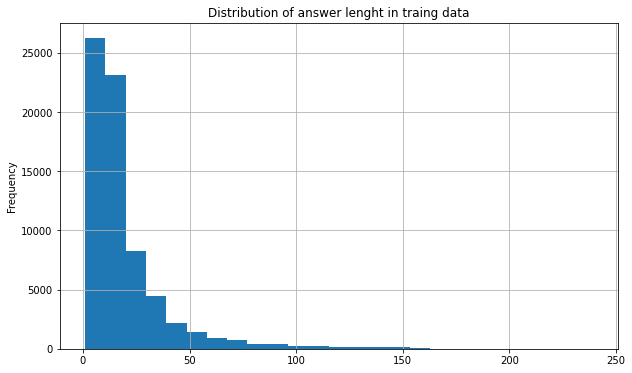

In [9]:
train_df['answer_text'].apply(len).plot.hist(title="Distribution of answer lenght in traing data", bins=25, figsize=figsize, grid=True)

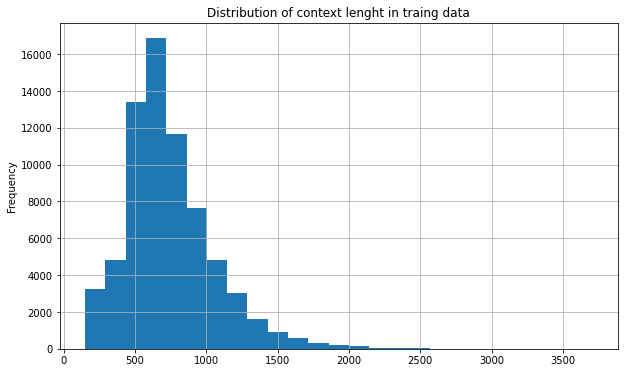

In [10]:
train_df['context'].apply(len).plot.hist(title="Distribution of context lenght in traing data", bins=25, figsize=figsize, grid=True)

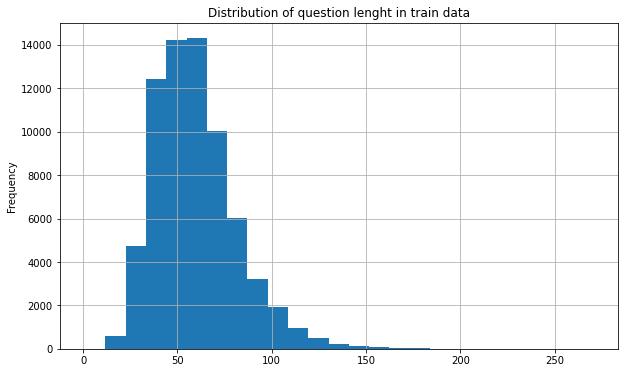

In [11]:
train_df['question'].apply(len).plot.hist(title="Distribution of question lenght in train data", bins=25, figsize=figsize, grid=True)

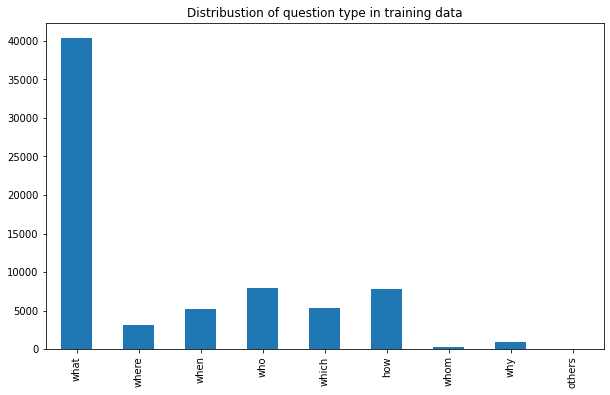

In [12]:
def find_question_type(df):
    len_df = len(df['question'])

    what = len(df[df['question'].str.contains('what', case=False, regex=False)]) 
    where = len(df[df['question'].str.contains('where', case=False, regex=False)]) 
    when = len(df[df['question'].str.contains('when', case=False, regex=False)]) 
    who = len(df[df['question'].str.contains('who', case=False, regex=False)]) 
    which = len(df[df['question'].str.contains('which', case=False, regex=False)]) 
    how = len(df[df['question'].str.contains('how', case=False, regex=False)])
    whom = len(df[df['question'].str.contains('whom', case=False, regex=False)])
    why = len(df[df['question'].str.contains('why', case=False, regex=False)])

    others = len_df - what - where - when - who - which - how - whom - why

    # In case of duplicates picked up by contains
    if others < 0:
        others = 0

    return what, where, when, who, which, how, whom, why, others

question_type = find_question_type(train_df)
plotdata = pd.DataFrame({"question": question_type}, index=["what", "where","when","who","which","how","whom", "why", "others"])
plotdata['question'].plot(kind="bar",title="Distribustion of question type in training data", figsize=figsize)

AutoTokenizer is a generic tokenizer class that will be instantiated as one of the tokenizer classes of the library when created with the AutoTokenizer.from_pretrained(pretrained_model_name_or_path) class method.

The from_pretrained() method takes care of returning the correct tokenizer class instance based on the model_type property of the config object, or when it’s missing, falling back to using pattern matching on the pretrained_model_name_or_path string:

In [13]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

## Preprocessing


In [14]:
dataset = load_dataset('json', data_files={"train":data_path+"train.json", "valid":data_path+"valid.json"}, field="data")

Using custom data configuration default-a55bb0ab92d81eb8


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-a55bb0ab92d81eb8/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
max_len = 384

def preprocess_function(dataset):
    inputs = tokenizer(dataset["question"],
                        dataset["context"],
                        max_length = max_len,
                        truncation="only_second",
                        return_offsets_mapping=True,
                        padding="max_length")

    offset_mapping = inputs.pop("offset_mapping")
    answers_start = dataset["answer_start"]
    answers_text = dataset['answer_text']
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        start_char = answers_start[i]
        end_char = answers_start[i] + len(answers_text[i])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

Use Datasets map function to apply the preprocessing function over the entire dataset. You can speed up the map function by setting batched=True to process multiple elements of the dataset at once. Remove the columns you don’t need

In [16]:
tokenized_squad = dataset.map(preprocess_function, batched=True, remove_columns=dataset["train"].column_names)

  0%|          | 0/70 [00:00<?, ?ba/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

## Train

### Parameters

In [17]:
batch_size = 16
num_epochs = 2
learning_rate = 0.00001
num_warmup_steps = 0

We use DefaultDataCollator to create a batch of examples. Unlike other data collators in Transformers, the DefaultDataCollator does not apply additional preprocessing such as padding.

In [18]:
data_collator = DefaultDataCollator(return_tensors="tf")

train_set = tokenized_squad["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "start_positions", "end_positions"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,)

validation_set = tokenized_squad["valid"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "start_positions", "end_positions"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,)

In [19]:
total_train_steps = (len(tokenized_squad["train"]) // batch_size) * num_epochs

optimizer, schedule = create_optimizer(init_lr=learning_rate,
                                        num_warmup_steps=num_warmup_steps,
                                        num_train_steps=total_train_steps,)

model = TFAutoModelForQuestionAnswering.from_pretrained("distilbert-base-uncased")
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer=optimizer, 
              metrics=["accuracy"])

model.fit(train_set, validation_data=validation_set, epochs=num_epochs)
model.save_pretrained(data_path)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForQuestionAnswering: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
4337/4337 [==============================] - 3202s 736ms/step - loss: 3.5364 - end_logits_loss: 1.7185 - start_logits_loss: 1.8179 - end_logits_accuracy: 0.5489 - start_logits_accuracy: 0.5099 - val_loss: 2.8748 - val_end_logits_loss: 1.3892 - val_start_logits_loss: 1.4856 - val_end_logits_accuracy: 0.6250 - val_start_logits_accuracy: 0.5812
Epoch 2/2
2819/4337 [==================>...........] - ETA: 17:09 - loss: 2.2611 - end_logits_loss: 1.1046 - start_logits_loss: 1.1565 - end_logits_accuracy: 0.6930 - start_logits_accuracy: 0.6565

KeyboardInterrupt: ignored

## Evaluation